# HECATE-DS

Harvesting loCAl specTra with Exoplanets (Doppler Shadow)

I will run the modular components of the tool, including two main modules:

1. Extraction
2. Analysis

I will also add a class just for plots, a class to compute CCFs and a class to run SOAP.

this way, when the user wants to extract the local spectra, the code will fetch the auxiliar functions, but at the same time the user can run the CCFs and SOAP separately.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import glob

In [2]:
stellar_params = {
                "Teff":4969, "Teff_err":43,   #effective temperature [K]
                "logg":4.60, "logg_err":0.01, #superficial gravity [dex]
                "FeH":-0.07, "FeH_err":0.02,  #metallicity [dex]
                "P_rot":2.21857312,           #rotation period [d]
                "R_star":0.766,               #radius [solar radii]
                "inc_star":71.87              #stellar inclination [º]
                }

planet_params = {
                "P_orb":2.21857312,           #orbital period [d]
                "a_R":8.76863,                #system scale [stellar radii]
                "Rp_Rs":0.1602,               #planet-to-star radius ratio 
                "t0":53988.30339,             #mid-transit time [d]
                "e":0,                        #orbital eccentricity
                "w":90,                       #argument of periastron [º]
                "inc_planet":85.465,          #planet inclination [º]
                "lbda":-1.00,                 #spin-orbit angle [º]
                "dfp": -0.002424              #
                }

In [3]:
directory_path = 'Eduardos_code/white_light_ccfs/'
listfiles = glob.glob(os.path.join(directory_path, '*.fits'))

list_ccfs = [name for name in listfiles if '2021-08-11' in name and 'SKY' in name]
list_ccfs = sorted(list_ccfs)
#removing low SNR observation
list_ccfs = list_ccfs[:-1]

In [4]:
CCFs = np.zeros((len(list_ccfs), 3, 81))
time = np.zeros((len(list_ccfs)))

for i,name in enumerate(list_ccfs):

    d = fits.getdata(name,1)
    de = fits.getdata(name,2)
    h = fits.getheader(name)

    N = len(d[-1])
    a = h['HIERARCH ESO RV START']
    step = h['HIERARCH ESO RV STEP']
    t = h['HIERARCH ESO QC BJD']
    time[i] = t
    X = np.arange(a,a+step*N,step)

    CCFs[i,0,:] = d[-1]
    CCFs[i,1,:] = de[-1]
    CCFs[i,2,:] = X

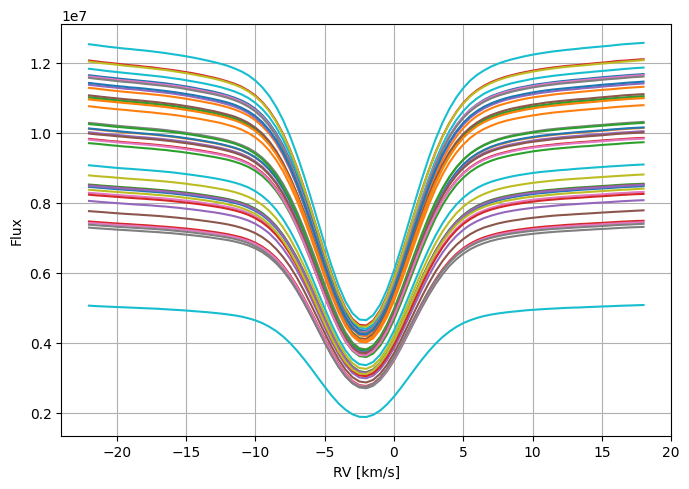

In [5]:
fig, ax = plt.subplots(figsize=(7,5))
for i in range(CCFs.shape[0]):
    ax.plot(CCFs[i,2], CCFs[i,0])
ax.set_xlabel("RV [km/s]")
ax.set_ylabel("Flux")
ax.grid()
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [6]:
from run_SOAP import run_SOAP

Flux_SOAP = run_SOAP(time, stellar_params, planet_params, plot=False).flux

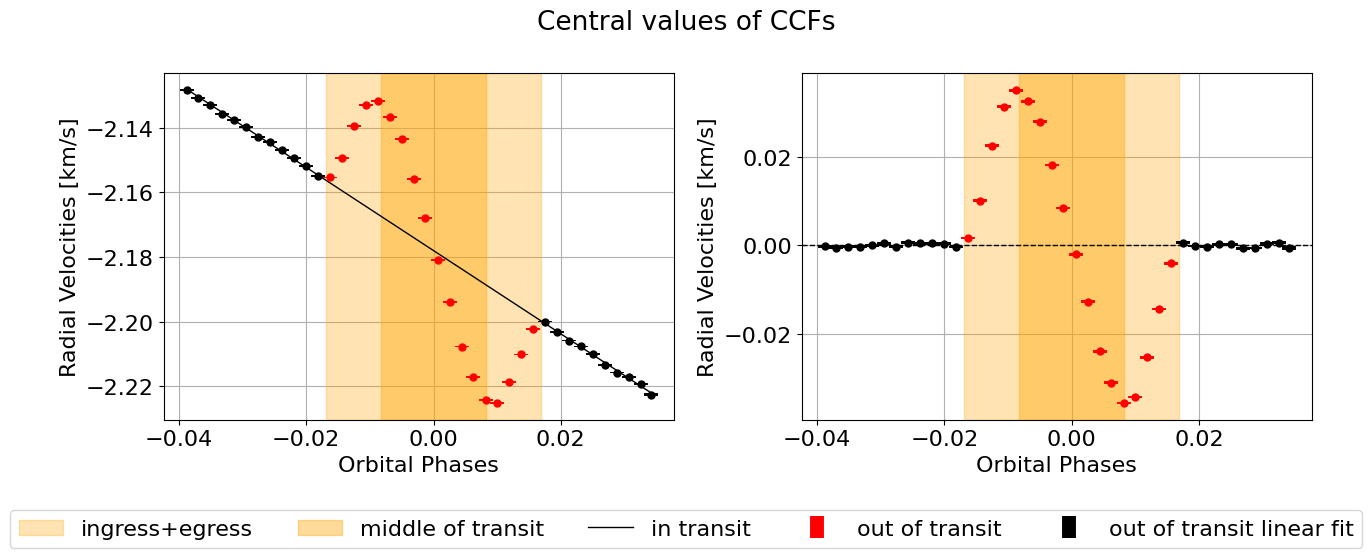

In [7]:
from RM_correction import RM_correction
rm_corr = RM_correction(planet_params, time, CCFs, model="Dravins", plot_fits=False, plot_rm=True)

CCFs_RM_corr = rm_corr.CCFs_RM_corr
x0_corr = rm_corr.x0_corr

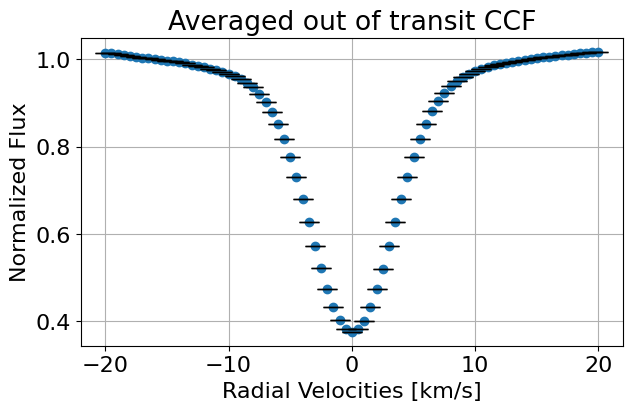

(array([[[ 1.01571486e+00,  1.01367084e+00,  1.01169313e+00, ...,
           1.01512551e+00,  1.01611895e+00,  1.01722816e+00],
         [ 2.47124657e-04,  1.49706951e-04,  1.49109881e-04, ...,
           1.48936497e-04,  1.51392324e-04,  1.49560502e-04],
         [-2.00000000e+01, -1.95000000e+01, -1.90000000e+01, ...,
           1.90000000e+01,  1.95000000e+01,  2.00000000e+01]],
 
        [[ 1.01577593e+00,  1.01368116e+00,  1.01154184e+00, ...,
           1.01520890e+00,  1.01644106e+00,  1.01745314e+00],
         [ 2.24571947e-04,  1.34978637e-04,  1.37869798e-04, ...,
           1.37276971e-04,  1.38037068e-04,  1.36006096e-04],
         [-2.00000000e+01, -1.95000000e+01, -1.90000000e+01, ...,
           1.90000000e+01,  1.95000000e+01,  2.00000000e+01]],
 
        [[ 1.01527454e+00,  1.01338843e+00,  1.01136658e+00, ...,
           1.01532377e+00,  1.01624433e+00,  1.01723669e+00],
         [ 2.46662727e-04,  1.48187344e-04,  1.47783465e-04, ...,
           1.47853305e-04,  1.49

In [8]:
from HECATE_DS import HECATE

HECATE = HECATE()

RV_reference = np.arange(-20,20.5,0.5)

HECATE._avg_out_of_transit_CCF(planet_params, time, CCFs_RM_corr, RV_reference, plot=True, save=None)

In [6]:
plot = {"SOAP":False, "fits_initial_CCF":False, "RM":False, "avg_out_of_transit_CCF":False, "local_CCFs":True}

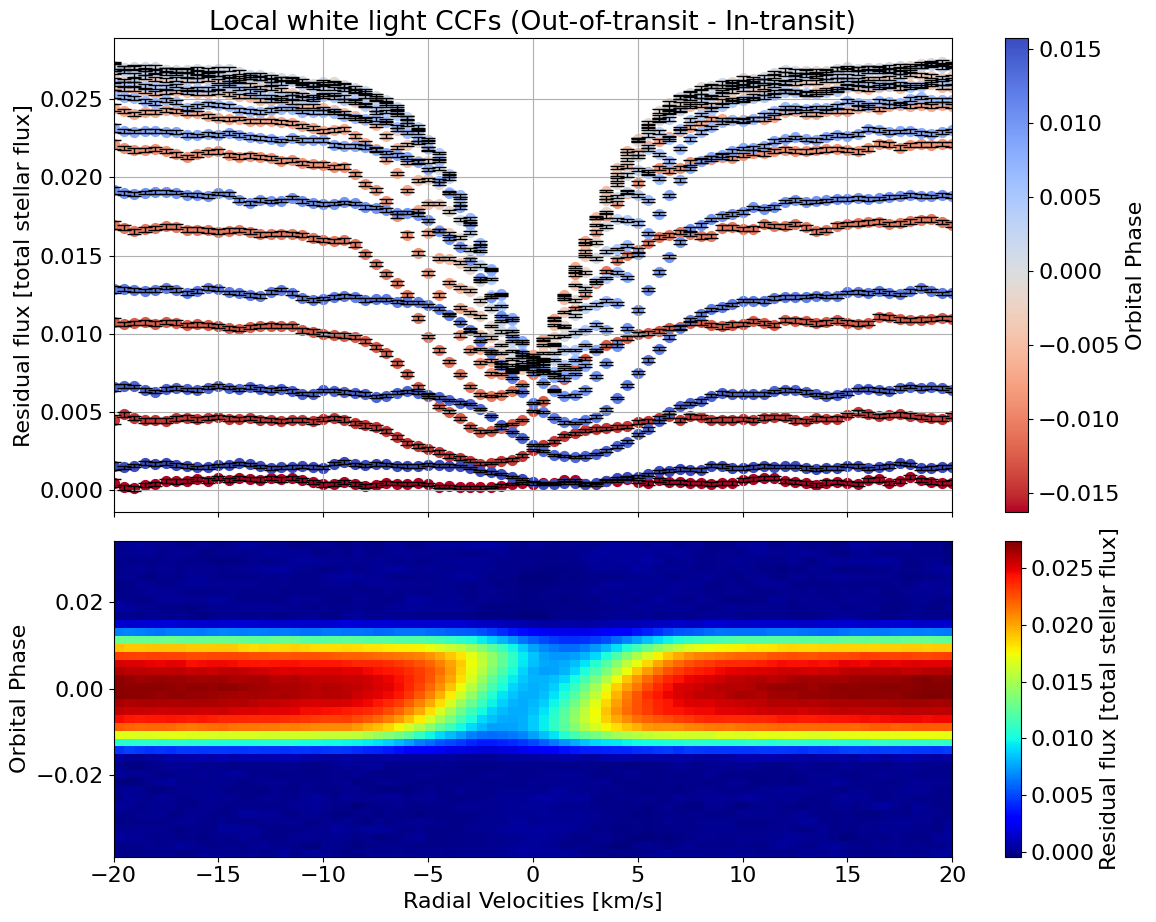

In [7]:
from HECATE_DS import HECATE

HECATE = HECATE()

RV_reference = np.arange(-20,20.5,0.5)

ccf_type = "white light"

HECATE._extract_local_CCF(planet_params, stellar_params, RV_reference, time, CCFs, ccf_type, plot, save=None)